# Phase 1 — Data Quality / EDA

> Goals: sanity-check raw and processed datasets, quantify missingness/duplicates/sparsity, and surface quick insights to guide Phase 2 cleaning & feature engineering.

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_colwidth', 200)

# Resolve project root so notebook runs from any working directory (e.g., notebooks/)
def find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'data').exists() and ((p / 'requirements.txt').exists() or (p / '.git').exists()):
            return p
    return start

ROOT = find_project_root(Path.cwd())
print(f"Project root: {ROOT}")

EDA_DIR = ROOT / 'reports' / 'eda'
EDA_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR = ROOT / 'data' / 'raw'
PROC_DIR = ROOT / 'data' / 'processed'
ratings_path = RAW_DIR / 'rating.csv'
anime_path = RAW_DIR / 'anime.csv'
meta_path = PROC_DIR / 'anime_metadata.parquet'

# Helpful warning if files are missing
for p in [ratings_path, anime_path, meta_path]:
    if not p.exists():
        print(f"Warning: missing {p}")

ratings_path, anime_path, meta_path

Project root: c:\Users\dedwa\OneDrive\Desktop\Dromund_Kass\MARS\MyAnimeRecommendationSystem


(WindowsPath('c:/Users/dedwa/OneDrive/Desktop/Dromund_Kass/MARS/MyAnimeRecommendationSystem/data/raw/rating.csv'),
 WindowsPath('c:/Users/dedwa/OneDrive/Desktop/Dromund_Kass/MARS/MyAnimeRecommendationSystem/data/raw/anime.csv'),
 WindowsPath('c:/Users/dedwa/OneDrive/Desktop/Dromund_Kass/MARS/MyAnimeRecommendationSystem/data/processed/anime_metadata.parquet'))

In [2]:
# Load datasets

def load_or_raise(path: Path, loader):
    if not path.exists():
        raise FileNotFoundError(f"Expected file not found: {path}.\nCurrent working dir: {Path.cwd()}\nResolved ROOT: {ROOT}")
    return loader(path)

ratings = load_or_raise(ratings_path, pd.read_csv)
anime = load_or_raise(anime_path, pd.read_csv)
meta = load_or_raise(meta_path, pd.read_parquet)

ratings.head(), anime.head(), meta.head()

(   user_id  anime_id  rating
 0        1        20      -1
 1        1        24      -1
 2        1        79      -1
 3        1       226      -1
 4        1       241      -1,
    anime_id                              name  \
 0     32281                    Kimi no Na wa.   
 1      5114  Fullmetal Alchemist: Brotherhood   
 2     28977                          Gintama°   
 3      9253                       Steins;Gate   
 4      9969                     Gintama&#039;   
 
                                                           genre   type  \
 0                          Drama, Romance, School, Supernatural  Movie   
 1   Action, Adventure, Drama, Fantasy, Magic, Military, Shounen     TV   
 2  Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen     TV   
 3                                              Sci-Fi, Thriller     TV   
 4  Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen     TV   
 
   episodes  rating  members  
 0        1    9.37   200630  
 1 

In [3]:
# Shapes & basic info
n_ratings = len(ratings)
n_users = ratings['user_id'].nunique() if 'user_id' in ratings.columns else np.nan
n_items = ratings['anime_id'].nunique() if 'anime_id' in ratings.columns else np.nan
density = (n_ratings / (n_users * n_items)) if (n_users and n_items and n_users>0 and n_items>0) else np.nan

summary = {
    'ratings_rows': int(n_ratings),
    'ratings_users_unique': int(n_users) if not np.isnan(n_users) else None,
    'ratings_items_unique': int(n_items) if not np.isnan(n_items) else None,
    'ratings_density': float(density) if not np.isnan(density) else None,
    'anime_rows': int(len(anime)),
    'metadata_rows': int(len(meta)),
    'metadata_cols': int(len(meta.columns)),
}
summary

{'ratings_rows': 7813737,
 'ratings_users_unique': 73515,
 'ratings_items_unique': 11200,
 'ratings_density': 0.009489969248258373,
 'anime_rows': 12294,
 'metadata_rows': 12297,
 'metadata_cols': 18}

<>:13: SyntaxWarning: invalid escape sequence '\ '
<>:13: SyntaxWarning: invalid escape sequence '\ '
C:\Users\dedwa\AppData\Local\Temp\ipykernel_13232\2941019404.py:13: SyntaxWarning: invalid escape sequence '\ '
  print('Column \rating\ not found in ratings.csv')


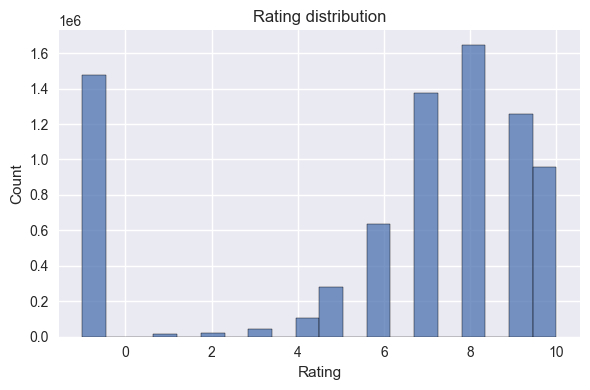

In [4]:
# Ratings distribution
fig, ax = plt.subplots(figsize=(6,4))
if 'rating' in ratings.columns:
    sns.histplot(ratings['rating'].dropna(), bins=20, kde=False, ax=ax)
    ax.set_title('Rating distribution')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    fig.tight_layout()
    out = EDA_DIR / 'ratings_distribution.png'
    fig.savefig(out, dpi=150)
    out
else:
    print('Column \rating\ not found in ratings.csv')

In [5]:
# Duplicate and null checks in ratings
dup_count = ratings.duplicated(subset=[c for c in ['user_id','anime_id'] if c in ratings.columns]).sum()
nulls = ratings.isna().sum().to_dict()
quality_summary = {
    'duplicates_user_item': int(dup_count),
    'null_counts': {k:int(v) for k,v in nulls.items()}
}
with open(EDA_DIR / 'ratings_quality_summary.json', 'w', encoding='utf-8') as f:
    json.dump(quality_summary, f, indent=2)
quality_summary

{'duplicates_user_item': 7,
 'null_counts': {'user_id': 0, 'anime_id': 0, 'rating': 0}}

In [6]:
# Metadata missingness for key fields
key_fields = [
    'title_primary','synopsis','episodes','status','aired_from','aired_to',
    'mal_score','mal_rank','mal_popularity','members_count','retrieved_at'
]
missing = {k: int(meta[k].isna().sum()) for k in key_fields if k in meta.columns}
missing

{'title_primary': 114,
 'synopsis': 400,
 'episodes': 142,
 'status': 114,
 'aired_from': 135,
 'aired_to': 6088,
 'mal_score': 1301,
 'mal_rank': 1925,
 'mal_popularity': 114,
 'members_count': 114,
 'retrieved_at': 0}

Column: genres
dtype: object
top types:
 genres
ndarray    12297
Name: count, dtype: int64
sample[0] type=ndarray -> array(['Action', 'Award Winning', 'Sci-Fi'], dtype=object)
sample[1] type=ndarray -> array(['Action', 'Sci-Fi'], dtype=object)
sample[2] type=ndarray -> array(['Action', 'Adventure', 'Sci-Fi'], dtype=object)
sample[3] type=ndarray -> array(['Action', 'Drama', 'Mystery', 'Supernatural'], dtype=object)
sample[4] type=ndarray -> array(['Action', 'Adventure', 'Fantasy'], dtype=object)
--------------------------------------------------------------------------------
Column: themes
dtype: object
top types:
 themes
ndarray    12297
Name: count, dtype: int64
sample[0] type=ndarray -> array(['Adult Cast', 'Space'], dtype=object)
sample[1] type=ndarray -> array(['Adult Cast', 'Space'], dtype=object)
sample[2] type=ndarray -> array(['Adult Cast'], dtype=object)
sample[3] type=ndarray -> array(['Detective'], dtype=object)
sample[4] type=ndarray -> array([], dtype=object)
------------

(WindowsPath('c:/Users/dedwa/OneDrive/Desktop/Dromund_Kass/MARS/MyAnimeRecommendationSystem/reports/eda/top_genres_themes.png'),
 Comedy           4278
 Action           2329
 Adventure        2308
 Fantasy          2289
 Sci-Fi           2145
 Drama            1948
 Romance          1356
 Hentai           1129
 Supernatural      888
 Slice of Life     704
 Ecchi             650
 Mystery           576
 Sports            480
 Horror            370
 Avant Garde       289
 Suspense          209
 Award Winning     190
 Boys Love         101
 Girls Love         78
 Gourmet            69
 dtype: int64,
 School             1319
 Mecha               913
 Music               899
 Historical          844
 Military            470
 Parody              444
 Space               432
 Super Power         426
 Adult Cast          382
 Mythology           345
 Harem               340
 Martial Arts        268
 Psychological       263
 Mahou Shoujo        214
 Team Sports         210
 Detective           

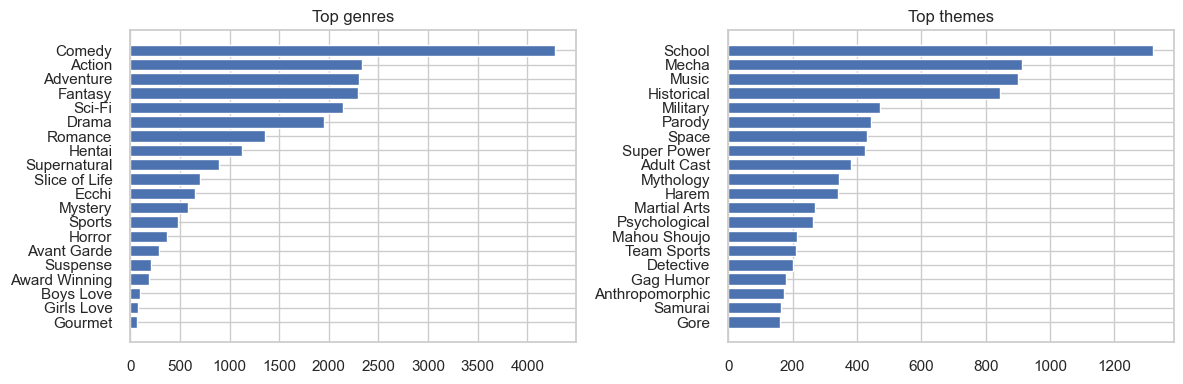

In [12]:
# Diagnostics: peek at raw values and types for genres/themes
cols = ['genres', 'themes']
for c in cols:
    s = meta[c]
    print(f"Column: {c}")
    print("dtype:", s.dtype)
    # value types
    types = s.map(lambda x: type(x).__name__ if x is not None else 'None').value_counts().head(10)
    print("top types:\n", types)
    # sample non-null values
    nn = s.dropna().head(5).tolist()
    for i, v in enumerate(nn):
        print(f"sample[{i}] type={type(v).__name__} ->", repr(v)[:300])
    print('-' * 80)

# If they look like list[dict], show first item keys to guide parsing
if meta['genres'].dropna().shape[0] > 0:
    first = meta['genres'].dropna().iloc[0]
    if isinstance(first, (list, tuple)) and len(first) > 0:
        print("genres first element type:", type(first[0]).__name__)
        if isinstance(first[0], dict):
            print("genres first dict keys:", list(first[0].keys()))

# Re-run counts using a parser that handles list[dict] with 'name' field and numpy arrays
from collections import Counter
import numpy as np

def extract_names(value):
    # Accept: np.ndarray[str], list[dict{name: str}], list[str], JSON string, comma-separated string
    import json
    # Normalize numpy arrays to list
    if isinstance(value, np.ndarray):
        value = value.tolist()
    # Already list-like
    if isinstance(value, (list, tuple)):
        items = []
        for e in value:
            if isinstance(e, dict):
                # prefer 'name' or 'title'
                n = e.get('name') or e.get('title') or e.get('label')
                if n:
                    items.append(str(n))
            elif isinstance(e, str):
                items.append(e)
        return items
    # Try JSON
    if isinstance(value, str):
        s = value.strip()
        if s.startswith('[') or s.startswith('{'):
            try:
                obj = json.loads(s)
                return extract_names(obj)
            except Exception:
                pass
        # Fallback comma-separated
        if ',' in s:
            return [p.strip() for p in s.split(',') if p.strip()]
    return []

genre_names = meta['genres'].map(extract_names)
theme_names = meta['themes'].map(extract_names)

print("post-parse non-empty rows -> genres:", (genre_names.map(len) > 0).sum(), 
      "themes:", (theme_names.map(len) > 0).sum())

genre_counts = Counter([g for lst in genre_names for g in lst])
theme_counts = Counter([t for lst in theme_names for t in lst])

import pandas as pd

genre_counts = pd.Series(genre_counts).sort_values(ascending=False).head(20)
theme_counts = pd.Series(theme_counts).sort_values(ascending=False).head(20)

print("top genres:\n", genre_counts.head(10))
print("top themes:\n", theme_counts.head(10))

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if not genre_counts.empty:
    axes[0].barh(genre_counts.index[::-1], genre_counts.values[::-1])
    axes[0].set_title('Top genres')
else:
    axes[0].set_title('No genres available')

if not theme_counts.empty:
    axes[1].barh(theme_counts.index[::-1], theme_counts.values[::-1])
    axes[1].set_title('Top themes')
else:
    axes[1].set_title('No themes available')

plt.tight_layout()
EDA_DIR.mkdir(parents=True, exist_ok=True)
out = EDA_DIR / 'top_genres_themes.png'
fig.savefig(out)
out, genre_counts, theme_counts

In [13]:
# Persist normalized list columns for Phase 2 feature engineering
meta = meta.copy()
meta['genres_list'] = genre_names
meta['themes_list'] = theme_names

# Basic sanity: ensure they are lists
assert meta['genres_list'].map(lambda x: isinstance(x, list)).all()
assert meta['themes_list'].map(lambda x: isinstance(x, list)).all()

normalized_path = PROC_DIR / 'anime_metadata_normalized.parquet'
meta.to_parquet(normalized_path, index=False)
print('Saved normalized metadata to:', normalized_path)
normalized_path

Saved normalized metadata to: c:\Users\dedwa\OneDrive\Desktop\Dromund_Kass\MARS\MyAnimeRecommendationSystem\data\processed\anime_metadata_normalized.parquet


WindowsPath('c:/Users/dedwa/OneDrive/Desktop/Dromund_Kass/MARS/MyAnimeRecommendationSystem/data/processed/anime_metadata_normalized.parquet')

## Summary
- Ratings: inspected distribution, duplicates, and nulls.
- Metadata: summarized missingness for key fields; top genres/themes visualized.

### Suggested next actions
- Convert aired_from/ aired_to to datetime dtypes (Phase 2 normalize).
- Cast episodes to nullable Int64.
- Define a stable vocabulary for genres/themes and build multi-hot matrices.
- Consider dropping extremely rare genres/themes (coverage < 0.1%).